In [1]:
%load_ext autoreload
%autoreload 2
exec(open('init_notebook.py').read())
from matplotlib import pyplot as plt
from highD.HighD import HighD
from highD.Filter import Filter
from highD.Plot import Plot
from highD.Visualizer import GIF
from highD.helper import *

current working dirC:\Users\abjawad\Documents\GitHub\cogMod-driver-behavior-model\highd_tools


Index(['scenario_id', 'exec_num', 'frame', 'scenario_status', 'ego_id', 'c_x',
       'c_y', 'c_speed', 'c_acceleration', 'c_steer', 'c_throttle', 'c_brake',
       'perceived_c_x', 'perceived_c_y', 'perceived_c_speed', 'gaze_direction',
       'preceding_id', 'a_x', 'a_y', 'a_speed'],
      dtype='object')


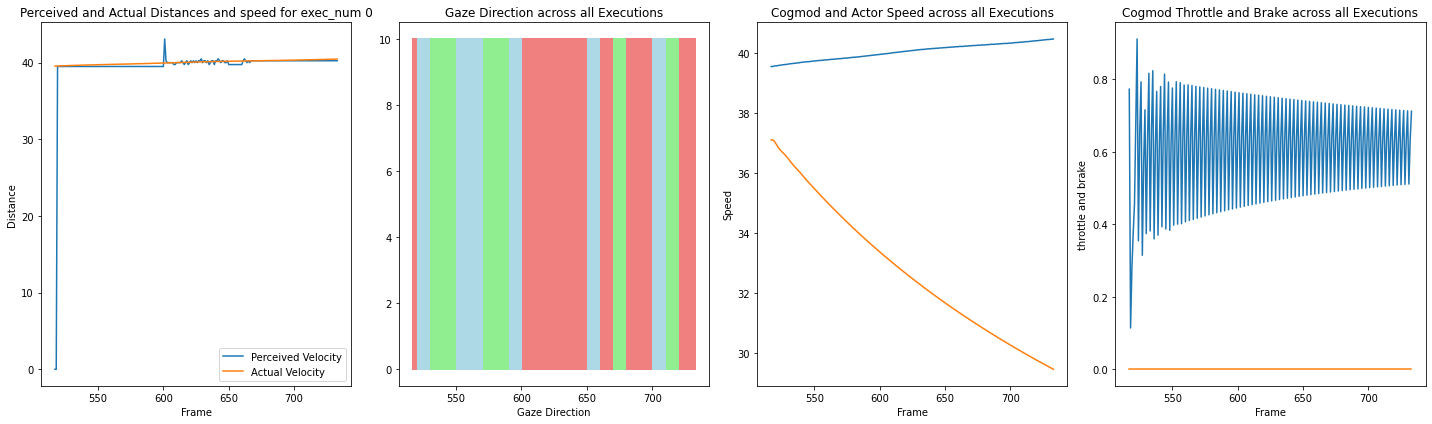

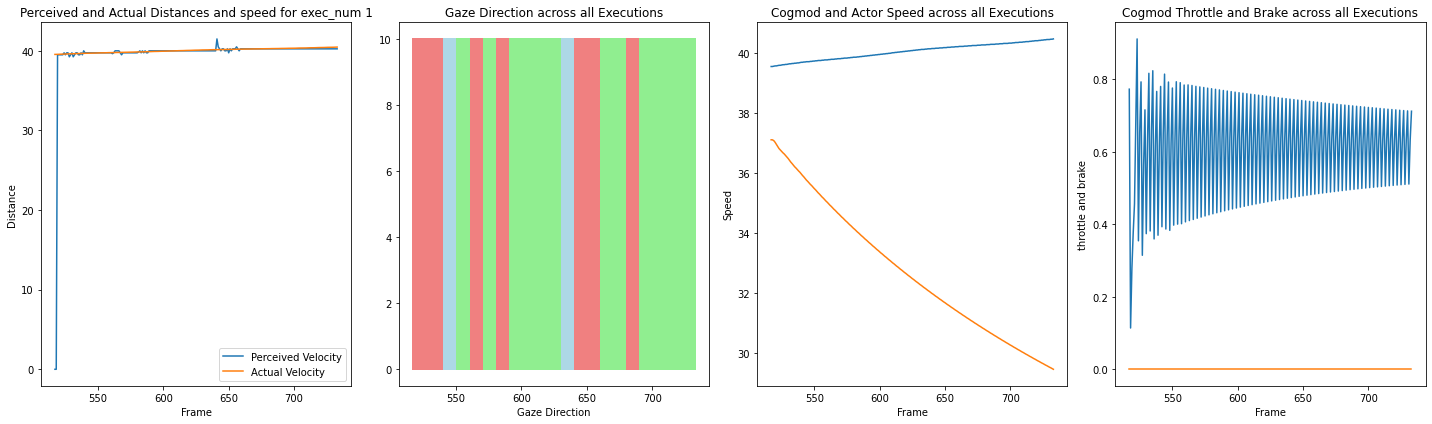

In [17]:

import os

def read_cogmod_files(file_names, COGMOD_LOGS):
    dfs = []
    for file_name in file_names:
        cogmod_file_path = os.path.join(COGMOD_LOGS, file_name)
        df = pd.read_csv(cogmod_file_path)
        dfs.append(df)
    return dfs

file_names = ["2023-05-18-19-41-15---1.csv", 
              "2023-05-18-20-06-56---1.csv", 
              "2023-05-18-20-22-56---1.csv",
              "2023-05-19-11-40-35---1.csv",
              "2023-05-21-01-21-40---0.csv",
              "2023-05-21-14-57-28---0.csv"]    
cogmod_dfs = read_cogmod_files(file_names, COGMOD_LOGS)
print(cogmod_dfs[0].columns)
# cogmod_dfs[0].head()
Plot.plot_individual_exec_nums(cogmod_dfs[-1])

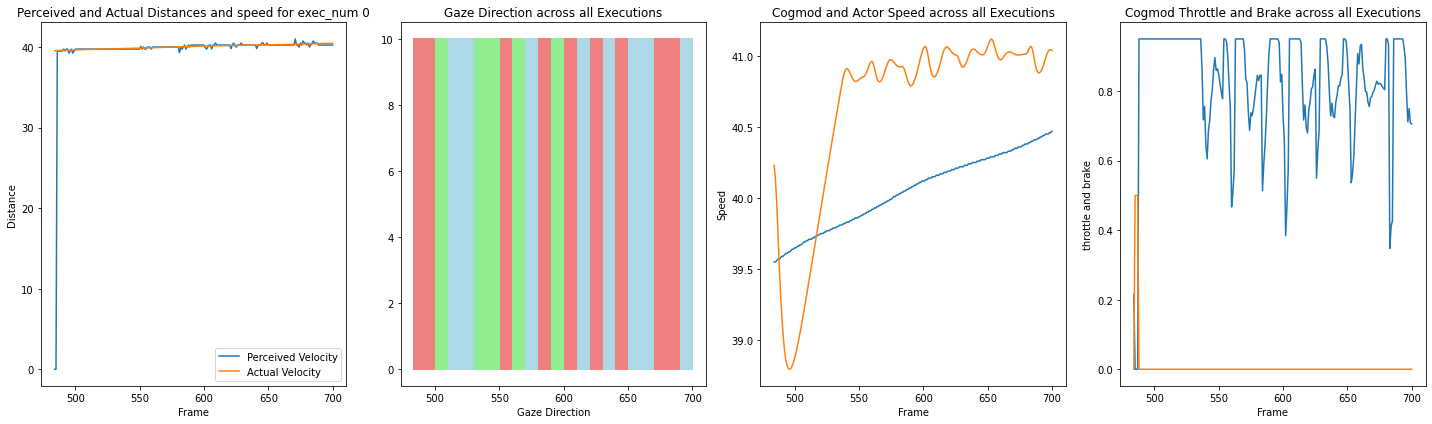

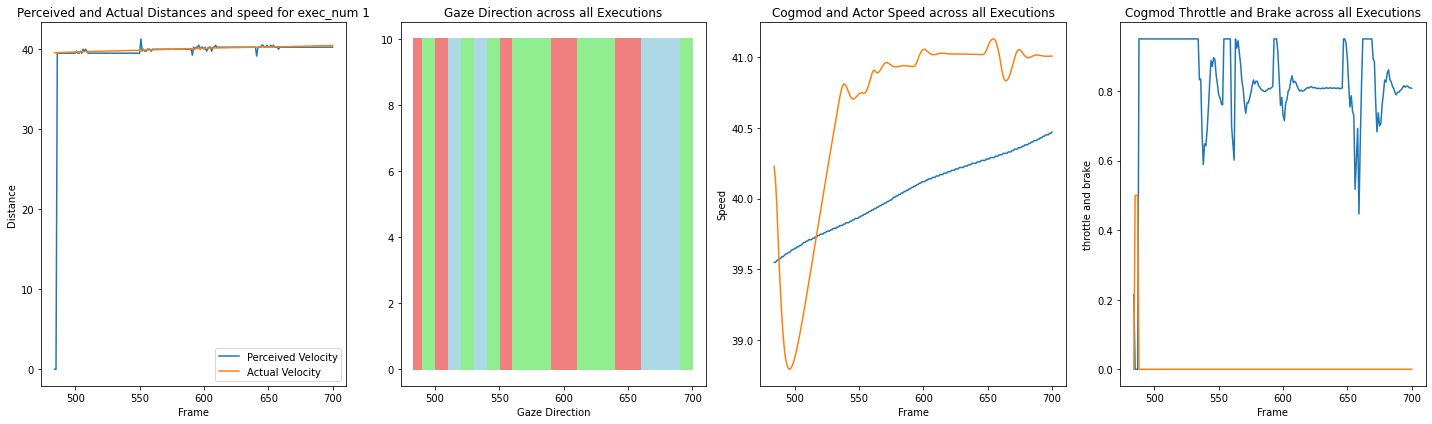

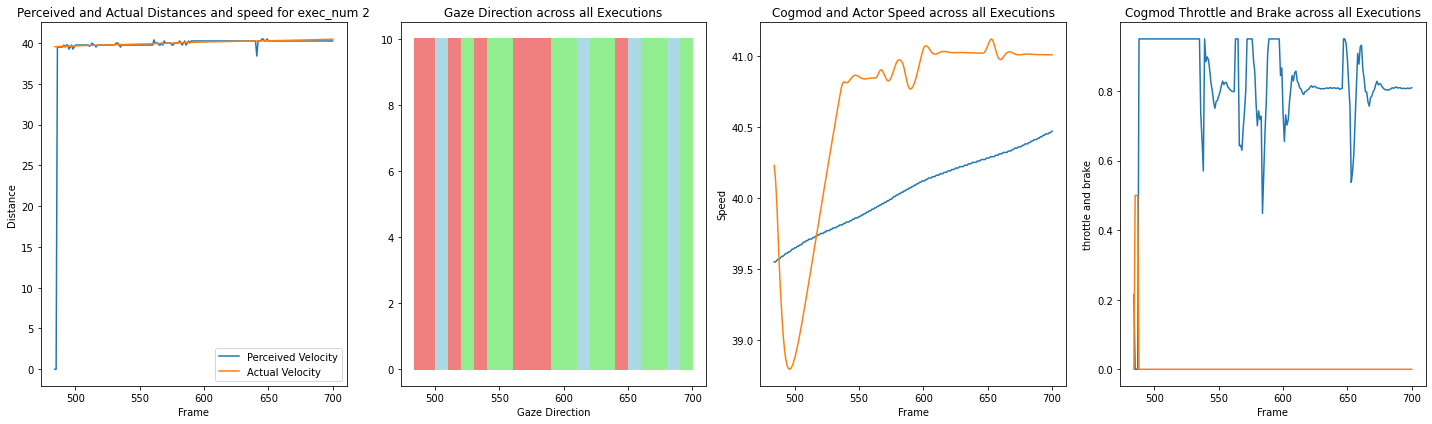

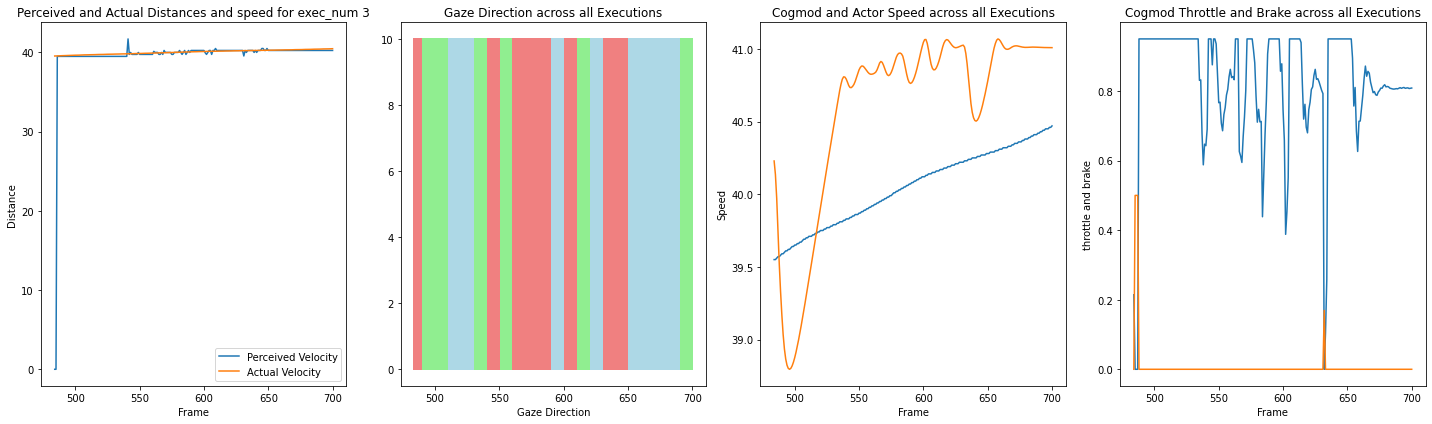

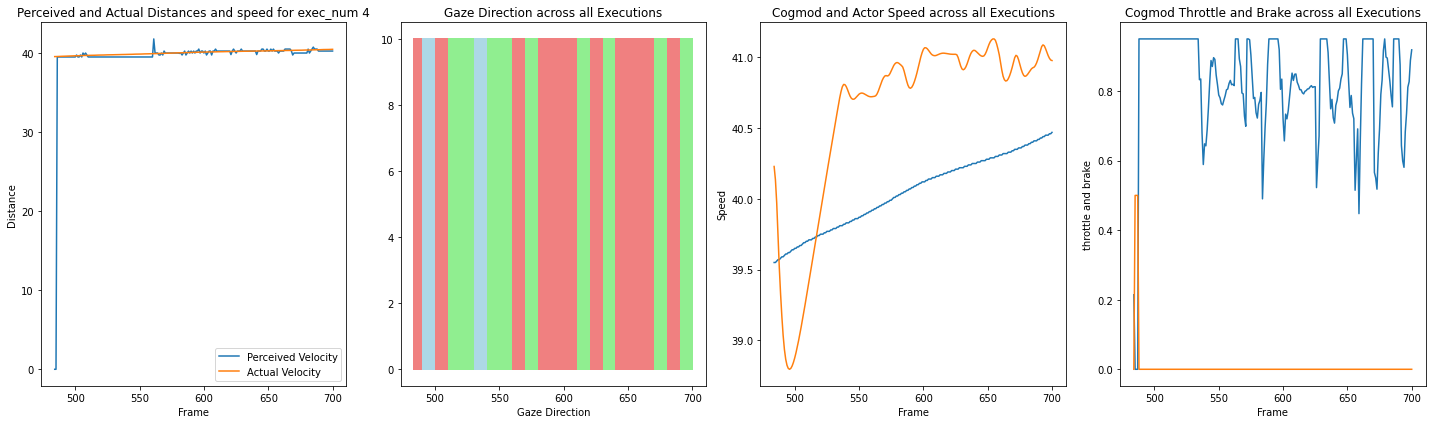

In [15]:
Plot.plot_individual_exec_nums(cogmod_dfs[-2])

In [ ]:
# Plot.plot_all_exec_nums(cogmod_dfs[0])
Plot.plot_all_exec_nums(cogmod_dfs[0])
Plot.plot_all_exec_nums(cogmod_dfs[-1])

In [ ]:
Plot.plot_individual_exec_nums(cogmod_dfs[5])

In [ ]:
import numpy as np

df = cogmod_dfs[-1]
# Assuming the DataFrame is named 'df'

# Calculate distance between ego vehicle and preceding vehicle
distance = np.sqrt((df['c_x'] - df['a_x'])**2 + (df['c_y'] - df['a_y'])**2)

# Calculate relative speed between ego vehicle and preceding vehicle
relative_speed = df['c_speed'] - df['a_speed']

# Avoid division by zero when calculating TTC
relative_speed = np.where(relative_speed != 0, relative_speed, 1e-6)

# Calculate TTC
ttc = distance / relative_speed

ttc = ttc[ttc < 200]
ttc = ttc[ttc > 0]

plt.hist(ttc, bins=20, edgecolor='black')
plt.xlabel('TTC Values')
plt.ylabel('Frequency')
plt.title('Distribution of TTC')
plt.show()


In [ ]:
# print all unique scenario id 
print(cogmod_dfs[0]['exec_num'].unique())

In [ ]:
#  nCarFollow 256, filter criteria {'thw_lower_bound': 0, 'thw_upper_bound': 4, 'time_duration': 5, 'distance_threshold': 50}